In [21]:
# Run this cell just once at the beginning, then restart the kernel

# Install correct NumPy version FIRST
!pip install numpy==1.26.4 --force-reinstall

# Then install PyTorch and PyG packages compatible with CUDA 11.8
!pip install torch==2.0.1+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-geometric


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [ ]:
#import os; os.kill(os.getpid(), 9)

In [1]:
# Run this as a check

import torch
import numpy as np
print(torch.__version__)        # Should be 2.0.1
print(np.__version__)           # Should be 1.26.4
print(torch.tensor([1.0]).numpy())  # ✅ Should work fine


2.0.1+cu118
1.26.4
[1.]


In [2]:
# Import libraries
!pip install networkit
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
from scipy.optimize import minimize
from sklearn.cluster import KMeans
import random
import cupy as cp
import networkit as nk

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = '/content/drive/MyDrive/Data'

# Load datasets
projects_df      = pd.read_excel(data_dir + "/project.xlsx")
publications_df  = pd.read_excel(data_dir + "/publications.xlsx")
deliverables_df  = pd.read_excel(data_dir + "/deliverables.xlsx")
organization_df  = pd.read_excel(data_dir + "/organization.xlsx")
euroSciVoc_df    = pd.read_excel(data_dir + "/euroSciVoc.xlsx")
topics_df        = pd.read_excel(data_dir + "/topics.xlsx")

projects_df.rename(columns={'id': 'projectID'}, inplace=True)

for df in (projects_df, organization_df, euroSciVoc_df,
           publications_df, deliverables_df):
    df['projectID'] = df['projectID'].astype(str)


In [5]:
# Correct mapper for org IDs
class IdMapper:
    """Bijective map str <-> int for networkit."""
    def __init__(self):
        self.str2int, self.int2str = {}, []

    def get(self, name):
        if name not in self.str2int:
            idx = len(self.int2str)
            self.str2int[name] = idx
            self.int2str.append(name)
        return self.str2int[name]

    def name(self, idx):
        return self.int2str[idx]

org_map   = IdMapper()

In [6]:
# Normalize Organization Names
organization_df['name'] = organization_df['name'].str.strip().str.lower()
projects_df['projectID'] = projects_df['projectID'].astype(str)
organization_df['projectID'] = organization_df['projectID'].astype(str)
deliverables_df['projectID'] = deliverables_df['projectID'].astype(str)
publications_df['projectID'] = publications_df['projectID'].astype(str)

# Initialize Graph and Mappings
G_org = nk.graph.Graph(directed=False, weighted=False)
org_edge_attr = {}  # (min(u,v), max(u,v)) -> dict of attributes

# Add Unique Nodes for Organizations
for org_name in organization_df['name'].unique():
    G_org.addNode()           # Node index = current graph size
    org_map.get(org_name)     # Ensure mapping (str <-> int)

# Precompute Project Stats with Full Metadata
project_stats = {}

for pid in organization_df['projectID'].unique():
    deliverables = deliverables_df[deliverables_df.projectID == pid][
        ['title', 'deliverableType', 'url']
    ].dropna(subset=['title']).drop_duplicates().to_dict('records')

    publications = publications_df[publications_df.projectID == pid][
        ['title', 'authors']
    ].dropna(subset=['title']).drop_duplicates().to_dict('records')

    meta = projects_df[projects_df.projectID == pid]
    if not meta.empty:
        row = meta.iloc[0]
        metadata = {
            "projectID": pid,
            "totalCost": row.get("totalCost"),
            "startDate": row.get("startDate"),
            "endDate": row.get("endDate"),
            "status": row.get("status"),
            "fundingScheme": row.get("fundingScheme")
        }
    else:
        metadata = {
            "projectID": pid,
            "totalCost": None,
            "startDate": None,
            "endDate": None,
            "status": None,
            "fundingScheme": None
        }

    project_stats[pid] = {
        "deliverables": deliverables,
        "publications": publications,
        "metadata": metadata
    }

# Build Edges Based on Co-Participation in Projects
for pid, group in organization_df.groupby('projectID'):
    org_names = group['name'].dropna().unique()
    dl = project_stats[pid]["deliverables"]
    pub = project_stats[pid]["publications"]
    meta = project_stats[pid]["metadata"]

    project_entry = {
        "projectID": pid,
        "totalCost": meta["totalCost"],
        "startDate": meta["startDate"],
        "endDate": meta["endDate"],
        "status": meta["status"],
        "fundingScheme": meta["fundingScheme"],
        "deliverables": dl,
        "publications": pub
    }

    for i, o1 in enumerate(org_names[:-1]):
        for o2 in org_names[i+1:]:
            u, v = org_map.get(o1), org_map.get(o2)
            key = (min(u, v), max(u, v))

            if not G_org.hasEdge(u, v):
                G_org.addEdge(u, v)
                org_edge_attr[key] = {"projects": [project_entry]}
            else:
                org_edge_attr[key]["projects"].append(project_entry)

# Add Node Attributes (e.g., Country)
org_node_attr = {}  # org_id (int) -> dict of attributes

for _, row in organization_df.drop_duplicates(subset='name').iterrows():
    org_name = row['name']
    org_id = org_map.get(org_name)
    org_node_attr[org_id] = {
        "country": row['country'].strip().lower() if pd.notnull(row['country']) else None
    }

# Summary
print(f"Organization layer created:")
print(f"  • Nodes : {G_org.numberOfNodes():,}")
print(f"  • Edges : {G_org.numberOfEdges():,}")


Organization layer created:
  • Nodes : 27,224
  • Edges : 751,350


In [7]:
# Inspect the largest 5 components

comp_org = nk.components.ConnectedComponents(G_org); comp_org.run()
components_org_sorted = sorted(comp_org.getComponents(), key=len, reverse=True)

print("\nOrganization layer largest components:")
for i, comp in enumerate(components_org_sorted[:5], start=1):
    sg = nk.graphtools.subgraphFromNodes(G_org, comp)
    print(f"  #{i}: {len(comp):,} nodes, {sg.numberOfEdges():,} edges")


Organization layer largest components:
  #1: 26,498 nodes, 751,285 edges
  #2: 5 nodes, 10 edges
  #3: 5 nodes, 10 edges
  #4: 4 nodes, 6 edges
  #5: 3 nodes, 3 edges


In [8]:
def relabel_graph(G_nk):
    """
    Returns a relabeled version of G_nk with node IDs 0..n-1.
    Also returns a dict: old_id -> new_id
    """
    old_nodes = list(G_nk.iterNodes())
    id_map = {old: new for new, old in enumerate(sorted(old_nodes))}

    G_new = nk.graph.Graph(n=G_nk.numberOfNodes(), directed=G_nk.isDirected(), weighted=G_nk.isWeighted())
    for u, v in G_nk.iterEdges():
        G_new.addEdge(id_map[u], id_map[v])

    return G_new, id_map


In [9]:
# Organization giant component extraction & relabel
giant_org_nodes = set(components_org_sorted[0])
G_org_gc = nk.graphtools.subgraphFromNodes(G_org, list(giant_org_nodes))
giantG_org, org_id_map = relabel_graph(G_org_gc)

# Remap edge attributes using new IDs
org_edge_attr_gc = {}
for (u, v), d in org_edge_attr.items():
    if u in giant_org_nodes and v in giant_org_nodes:
        u_new = org_id_map[u]
        v_new = org_id_map[v]
        key = (min(u_new, v_new), max(u_new, v_new))
        org_edge_attr_gc[key] = d

In [10]:
import math

def layer_stats(G, name, seed=42):
    """
    Compute basic stats on a graph component G using NetworKit:
      • n, m, avg_degree
      • diameter (exact)
      • avg clustering
      • max degree
    """
    n, m = G.numberOfNodes(), G.numberOfEdges()
    avg_deg = 2 * m / n

    # Diameter (exact)
    diam = nk.distance.Diameter(G)
    diam.run()
    d_val = diam.getDiameter()[0]

    # Average clustering (safe mean)
    cl = nk.centrality.LocalClusteringCoefficient(G)
    cl.run()
    cl_scores = cl.scores()
    avg_C = sum(cl_scores) / len(cl_scores) if cl_scores else float("nan")

    # Max degree
    max_deg = max(G.degree(u) for u in range(n))

    # Summary
    print(f"\n--- {name}  (giant component) ---")
    print(f"Nodes: {n:,}   Edges: {m:,}")
    print(f"Average degree      : {avg_deg:.2f}")
    print(f"Diameter            : {d_val}")
    print(f"Avg clustering coef.: {avg_C:.4f}")
    print(f"Max degree          : {max_deg}")

    return {
        "n": n,
        "m": m,
        "avg_degree": avg_deg,
        "diameter": d_val,
        "avg_clustering": avg_C,
        "max_degree": max_deg
    }

# Compute descriptive stats

stats_org = layer_stats(giantG_org, "Organization")
avg_C_org = stats_org["avg_clustering"]


--- Organization  (giant component) ---
Nodes: 26,498   Edges: 751,285
Average degree      : 56.71
Diameter            : 5
Avg clustering coef.: 0.8058
Max degree          : 5310


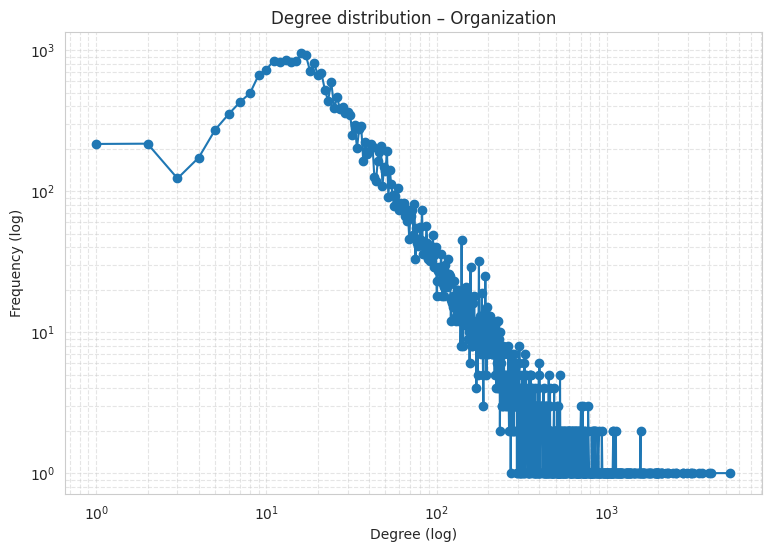


Organization degree stats  (GC)
  min: 1   max: 5310
  mean: 56.71   median: 23.00


In [11]:
from collections import Counter

def plot_degree_distribution(G, name):
    degs = [G.degree(u) for u in range(G.numberOfNodes())]
    cnt  = Counter(degs)
    x = np.array(sorted(cnt))
    y = np.array([cnt[k] for k in x])

    plt.figure(figsize=(9, 6))
    plt.loglog(x, y, 'o-'); plt.grid(True, which='both', ls='--', alpha=.5)
    plt.xlabel("Degree (log)"); plt.ylabel("Frequency (log)")
    plt.title(f"Degree distribution – {name}")
    plt.show()

    print(f"\n{name} degree stats  (GC)")
    print(f"  min: {min(degs)}   max: {max(degs)}")
    print(f"  mean: {np.mean(degs):.2f}   median: {np.median(degs):.2f}")

# Plot degree distribution
plot_degree_distribution(giantG_org, "Organization")


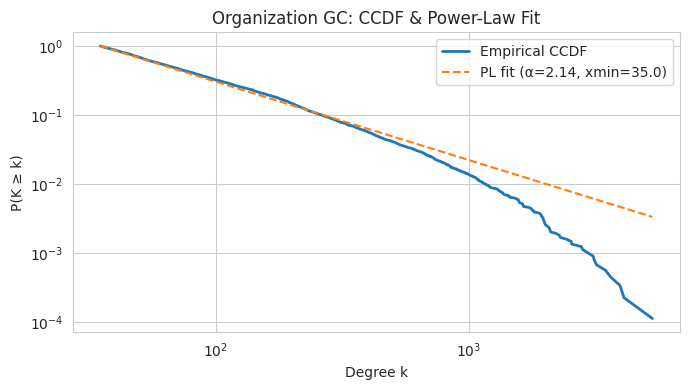

  → log-likelihood ratio R = 2643.97, p-value = 0.000



In [12]:
!pip install powerlaw
import powerlaw


def plot_ccdf_with_fit(degrees, title):
    # 1) Fit the tail
    fit = powerlaw.Fit(degrees, verbose=False)
    α    = fit.power_law.alpha
    xmin = fit.power_law.xmin
    fig, ax = plt.subplots(figsize=(7,4))

    # Plot the empirical CCDF
    fit.plot_ccdf(ax=ax, color='C0', linewidth=2, label='Empirical CCDF')

    # Plot the fitted power-law CCDF
    fit.power_law.plot_ccdf(
        ax=ax,
        color='C1',
        linestyle='--',
        label=f'PL fit (α={α:.2f}, xmin={xmin})'
    )

    ax.set_title(title)
    ax.set_xlabel("Degree k")
    ax.set_ylabel("P(K ≥ k)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Print likelihood-ratio vs exponential
    R, p = fit.distribution_compare('power_law', 'exponential')
    print(f"  → log-likelihood ratio R = {R:.2f}, p-value = {p:.3f}\n")

deg_org   = [giantG_org.degree(u) for u in range(giantG_org.numberOfNodes())]
plot_ccdf_with_fit(deg_org, "Organization GC: CCDF & Power-Law Fit")



In [13]:
# No need to check ER as the fit is already telling

# Non-overlapping community detection

from scipy.sparse import csgraph

def laplacian_eigenvalues(G_nk, k=10):
    """
    Compute the k smallest eigenvalues of the normalized Laplacian of G_nk.
    """
    n = G_nk.numberOfNodes()
    # Extract edge list from networkit as (u,v) tuples
    edge_list = list(G_nk.iterEdges())
    if not edge_list:
        return np.array([])

    rows, cols = zip(*edge_list)
    data = np.ones(len(rows), dtype=float)

    # Build adjacency matrix - for undirected graph, use 0.5 when symmetrizing
    A = csr_matrix((data, (rows, cols)), shape=(n, n))
    A = 0.5 * (A + A.T)  # proper symmetrization without doubling weights

    # Build normalized Laplacian: L = I - D^{-1/2} A D^{-1/2}
    L = csgraph.laplacian(A, normed=True)

    # Make sure k is not too large
    k_eig = min(k, n-2)
    vals, _ = eigsh(L, k=k_eig, which='SM', tol=1e-4)
    return np.sort(vals)

Org GC  first 10 normalized Laplacian eigenvalues:
 [3.64052239e-16 9.96103796e-02 1.50121335e-01 1.62459103e-01
 1.68455370e-01 1.70594910e-01 1.75796469e-01 1.89978044e-01
 1.93229419e-01 2.03915996e-01]


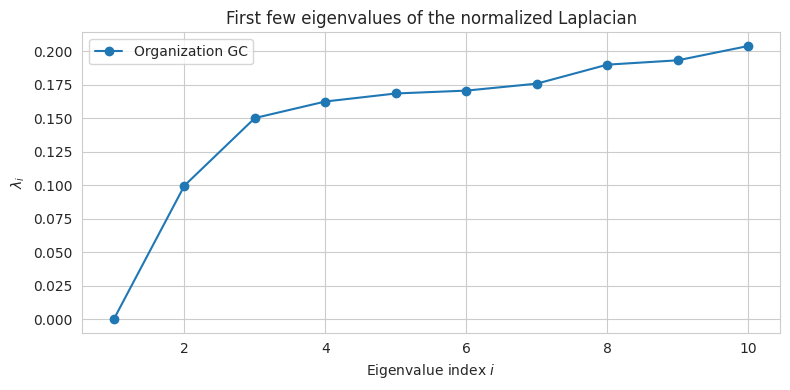

In [14]:
eig_org   = laplacian_eigenvalues(giantG_org,   k=10)

print("Org GC  first 10 normalized Laplacian eigenvalues:\n", eig_org)

# Plotting
plt.figure(figsize=(8,4))
plt.plot(range(1, len(eig_org)+1),   eig_org,   'o-', label='Organization GC')
plt.xlabel("Eigenvalue index $i$")
plt.ylabel(r"$\lambda_i$")
plt.title("First few eigenvalues of the normalized Laplacian")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Checking 2-way split leveraging on Cheeger inequality

def spectral_bisection_fast(G, max_iter=500):
    """Spectral bisection with power-iteration + sweep-cut for best conductance."""
    n = G.numberOfNodes()
    edge_list = list(G.iterEdges())
    rows, cols = zip(*edge_list)
    data = np.ones(len(rows), dtype=float)
    A = csr_matrix((data, (rows, cols)), shape=(n, n))
    A = 0.5 * (A + A.T)

    # Precompute D^{-1/2}
    degrees = np.array([G.degree(u) for u in range(n)], float)
    inv_sqrt = 1 / np.sqrt(degrees, where=(degrees > 0))
    D_inv_sqrt = csr_matrix((inv_sqrt, (range(n), range(n))), shape=(n, n))

    # Power‐iterate to approximate the Fiedler vector
    x = np.random.randn(n)
    x -= x.mean()
    x /= np.linalg.norm(x)

    for _ in range(max_iter):
        y = x - D_inv_sqrt @ (A @ (D_inv_sqrt @ x))
        y -= y.mean()
        norm_y = np.linalg.norm(y)
        if norm_y < 1e-10:
            break
        x = y / norm_y

        # ---- SWEEP‐CUT BEGIN ----
    order = np.argsort(x)
    best_phi, best_i = 1.0, None
    inS = np.zeros(n, bool)
    volS = 0.0
    cut = 0.0
    vol_total = degrees.sum()

    for i, u in enumerate(order[:-1], start=1):
        inS[u] = True
        volS += degrees[u]
        for v in A[u].indices:
            if inS[v]:
                cut -= 1
            else:
                cut += 1
        vol_comp = min(volS, vol_total - volS)
        phi_i = cut / vol_comp if vol_comp > 0 else np.inf
        if phi_i < best_phi:
            best_phi, best_i = phi_i, i

    # Build final partition
    S0 = set(order[:best_i])
    S1 = set(order[best_i:])
    phi = best_phi

    print(f"Found 2-way split with conductance φ = {phi:.4f}")
    print(f"Partition sizes: {len(S0)} vs {len(S1)} nodes")

    return S0, S1, x, phi  # Returning the full partitioning, Fiedler vector, and conductance

S0_org, S1_org, fiedler_org, phi_org= spectral_bisection_fast(giantG_org)

Found 2-way split with conductance φ = 0.4343
Partition sizes: 15416 vs 11082 nodes


In [16]:
# Conductance not really satisfying therefore proceding with overlapping community detection

def adjacency_matrix(G):
    n = G.numberOfNodes()
    edge_list = list(G.iterEdges())
    rows, cols = zip(*edge_list) if edge_list else ([], [])
    data = np.ones(len(rows), dtype=float)

    # Build symmetric adjacency (undirected)
    A = csr_matrix((data, (rows, cols)), shape=(n, n))
    A = A + A.T
    A[A > 1] = 1  # binary adjacency

    # Check degree sanity
    degrees = np.array(A.sum(axis=1)).flatten()
    print(f"Zero-degree nodes: {np.sum(degrees == 0)}")

    return cp.sparse.csr_matrix(A)

A_org = adjacency_matrix(giantG_org)

Zero-degree nodes: 0


In [17]:
# NMF factorization
def nmf_community_detection(A, n_components, max_iter=1000, init='nndsvda', random_state=42):
    """
    Apply NMF to the adjacency matrix to extract the community affiliation matrix F and the coefficient matrix H.
    """
    A = A.tocsr()
    A_dense = A.get().toarray()
    model = NMF(n_components=n_components, init=init, max_iter=max_iter, random_state=random_state)
    F = model.fit_transform(A_dense)
    H = model.components_
    return cp.array(F), cp.array(H)


In [18]:
F_nmf_org, H_nmf_org = nmf_community_detection(A_org, 5, init='nndsvda')

In [19]:
def relative_error(A, F, H):
    """
    Compute the relative Frobenius norm of the reconstruction error using CuPy.
    """
    # Reconstruction
    A_reconstructed = F @ H
    error = cp.linalg.norm(A.toarray() - A_reconstructed, ord='fro')
    norm_A = cp.linalg.norm(A.toarray(), ord='fro')

    return cp.asnumpy(error / norm_A)

In [20]:
rel_error_nmf_org = relative_error(A_org, F_nmf_org, H_nmf_org)
print(f"NMF Relative Reconstruction Error (Org): {rel_error_nmf_org:.4f}")

NMF Relative Reconstruction Error (Org): 0.9199


In [21]:
# Really poor performance on factorization: investigation of causes follows
def normalize_f(F):
    """
    Normalize the community affiliation matrix F row-wise.
    Each row will sum to 1.
    """
    row_sums = cp.sum(F, axis=1, keepdims=True)
    return F / row_sums

# Normalize F matrix
F_nmf_org_normalized = normalize_f(F_nmf_org)

# Identify nodes with strong overlaps (e.g., affiliation > threshold in multiple communities)
threshold = 0.4

overlapping_nodes_org = np.where((F_nmf_org_normalized > threshold).sum(axis=1) > 1)[0]
print("Nodes with strong overlaps in multiple communities (NMF):", overlapping_nodes_org)

# Identify single-community nodes
single_community_nodes_org = np.where((F_nmf_org_normalized > threshold).sum(axis=1) == 1)[0]
print("Nodes primarily belonging to one community (NMF):", single_community_nodes_org)


Nodes with strong overlaps in multiple communities (NMF): [    0    26    30 ... 26480 26481 26484]
Nodes primarily belonging to one community (NMF): [    2     3     5 ... 26495 26496 26497]


In [22]:
# multiple nodes belonging to one community --> possible sparsity

def analyze_sparsity(A):
    """
    Analyze the sparsity of the adjacency matrix.

    Parameters:
    - A: CuPy sparse matrix (CSR or COO format).

    Returns:
    - Sparsity ratio as a float.
    """
    total_elements = A.shape[0] * A.shape[1]
    non_zero_elements = A.nnz
    sparsity_ratio = 1 - (non_zero_elements / total_elements)

    print(f"Sparsity Ratio: {sparsity_ratio:.4f}")
    print(f"Non-Zero Elements: {non_zero_elements}")
    print(f"Total Elements: {total_elements}")

    return sparsity_ratio

# Example usage
sparsity_org = analyze_sparsity(A_org)


Sparsity Ratio: 0.9979
Non-Zero Elements: 1502570
Total Elements: 702144004


In [23]:
# switching to more suitable embedding --> Node2Vec

import torch.nn.functional as F
from torch_geometric.nn import Node2Vec, GAE, SAGEConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling, to_dense_adj


def get_edge_index_from_networkit(G):
    edge_list = list(G.iterEdges())
    src, dst = zip(*edge_list)
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    return edge_index

edge_index = get_edge_index_from_networkit(giantG_org)
print(edge_index.shape)  # should be (2, num_edges)

# Use all edges from the giant component
train_edges = list(org_edge_attr_gc.keys())


torch.Size([2, 751285])


In [24]:
# Convert to PyTorch edge_index
src, dst = zip(*train_edges)
edge_index_train = torch.tensor([src, dst], dtype=torch.long)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    edge_index=edge_index_train,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1, q=2,
    sparse=True
).to(device)

optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

def train_node2vec():
    model.train()
    total_loss = 0
    loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 21):
    loss = train_node2vec()
    print(f"[Node2Vec] Epoch {epoch:02d}, Loss: {loss:.4f}")

# Final Embedding
embeddings = model.embedding.weight.detach().cpu().numpy()

[Node2Vec] Epoch 01, Loss: 4.8370
[Node2Vec] Epoch 02, Loss: 2.6166
[Node2Vec] Epoch 03, Loss: 1.5717
[Node2Vec] Epoch 04, Loss: 1.1094
[Node2Vec] Epoch 05, Loss: 0.9199
[Node2Vec] Epoch 06, Loss: 0.8404
[Node2Vec] Epoch 07, Loss: 0.8027
[Node2Vec] Epoch 08, Loss: 0.7827
[Node2Vec] Epoch 09, Loss: 0.7704
[Node2Vec] Epoch 10, Loss: 0.7627
[Node2Vec] Epoch 11, Loss: 0.7575
[Node2Vec] Epoch 12, Loss: 0.7536
[Node2Vec] Epoch 13, Loss: 0.7514
[Node2Vec] Epoch 14, Loss: 0.7493
[Node2Vec] Epoch 15, Loss: 0.7475
[Node2Vec] Epoch 16, Loss: 0.7464
[Node2Vec] Epoch 17, Loss: 0.7460
[Node2Vec] Epoch 18, Loss: 0.7449
[Node2Vec] Epoch 19, Loss: 0.7444
[Node2Vec] Epoch 20, Loss: 0.7440


In [25]:
# Create Data object with all edges and Node2Vec embeddings
x = torch.tensor(embeddings, dtype=torch.float32).to(device)
src_train, dst_train = zip(*train_edges)
edge_index_train = torch.tensor([src_train, dst_train], dtype=torch.long).to(device)

data = Data(x=x, edge_index=edge_index_train)
data.train_pos_edge_index = edge_index_train

# GraphSAGE encoder with 3 layers, increased dims, dropout
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x


In [27]:
# Model and Optimizer
encoder = GraphSAGE(in_channels=128, hidden_channels=256, out_channels=128).to(device)
model = GAE(encoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

# Evaluation
@torch.no_grad()
def compute_metrics(z):
    model.eval()
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=z.size(0),
        num_neg_samples=data.train_pos_edge_index.size(1)
    )
    auc, ap = model.test(z, data.train_pos_edge_index, neg_edge_index)
    return auc, ap

# Training
def train_gae():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return loss, z

for epoch in range(1, 301):
    loss, z = train_gae()
    auc, ap = compute_metrics(z)
    scheduler.step(loss)
    if epoch % 10 == 0 or epoch == 1:
        print(f'[GAE] Epoch {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}')



[GAE] Epoch 001, Loss: 1.4249, AUC: 0.4832, AP: 0.5064
[GAE] Epoch 010, Loss: 1.3793, AUC: 0.7359, AP: 0.7586
[GAE] Epoch 020, Loss: 1.2252, AUC: 0.7699, AP: 0.7943
[GAE] Epoch 030, Loss: 1.1691, AUC: 0.7778, AP: 0.8200
[GAE] Epoch 040, Loss: 1.1396, AUC: 0.8151, AP: 0.8470
[GAE] Epoch 050, Loss: 1.1274, AUC: 0.8359, AP: 0.8616
[GAE] Epoch 060, Loss: 1.1134, AUC: 0.8417, AP: 0.8651
[GAE] Epoch 070, Loss: 1.0994, AUC: 0.8581, AP: 0.8756
[GAE] Epoch 080, Loss: 1.0788, AUC: 0.8653, AP: 0.8816
[GAE] Epoch 090, Loss: 1.0632, AUC: 0.8777, AP: 0.8897
[GAE] Epoch 100, Loss: 1.0740, AUC: 0.8785, AP: 0.8898
[GAE] Epoch 110, Loss: 1.0423, AUC: 0.8915, AP: 0.9026
[GAE] Epoch 120, Loss: 1.0431, AUC: 0.8847, AP: 0.8965
[GAE] Epoch 130, Loss: 1.0352, AUC: 0.9018, AP: 0.9102
[GAE] Epoch 140, Loss: 1.0238, AUC: 0.9005, AP: 0.9091
[GAE] Epoch 150, Loss: 1.0153, AUC: 0.9098, AP: 0.9163
[GAE] Epoch 160, Loss: 1.0084, AUC: 0.9155, AP: 0.9210
[GAE] Epoch 170, Loss: 1.0093, AUC: 0.9163, AP: 0.9218
[GAE] Epoc

In [28]:
@torch.no_grad()
def recommend_for_node(z, u, edge_index_existing, k=10):
    num_nodes = z.size(0)
    device = z.device
    connected = edge_index_existing[1][edge_index_existing[0] == u]
    mask = torch.ones(num_nodes, dtype=torch.bool, device=device)
    mask[connected] = False
    mask[u] = False
    candidates = torch.arange(num_nodes, device=device)[mask]
    scores = (z[u] * z[candidates]).sum(dim=1)
    topk_scores, topk_indices = torch.topk(scores, k)
    topk_nodes = candidates[topk_indices]
    topk_probs = torch.sigmoid(topk_scores)
    return topk_nodes.cpu(), topk_probs.cpu()

# Encode all embeddings
model.eval()
z = model.encode(data.x, data.train_pos_edge_index)

In [29]:
# Try only for testing

while True:
    try:
        u = int(input("Enter node ID (or -1 to exit): "))
        if u == -1:
            print("Exiting recommendation loop.")
            break
        if u < 0 or u >= z.size(0):
            print(f"Invalid node ID. Please enter an integer between 0 and {z.size(0) - 1}.")
            continue

        edge_index_existing = data.train_pos_edge_index  # use full graph
        top_nodes, top_probs = recommend_for_node(z, u, edge_index_existing, k=10)

        print(f"\nTop 10 recommended nodes for node {u} (with probabilities):\n")
        for rank, (v, prob) in enumerate(zip(top_nodes, top_probs), 1):
            print(f"{rank:02d}. Recommend edge ({u}, {v.item()}) with probability: {prob.item():.4f}")
        print("\n" + "-" * 40 + "\n")

    except ValueError:
        print("Invalid input. Please enter a valid integer.")

Enter node ID (or -1 to exit): 7865

Top 10 recommended nodes for node 7865 (with probabilities):

01. Recommend edge (7865, 19877) with probability: 0.9816
02. Recommend edge (7865, 2484) with probability: 0.9566
03. Recommend edge (7865, 3716) with probability: 0.9534
04. Recommend edge (7865, 24052) with probability: 0.9499
05. Recommend edge (7865, 23007) with probability: 0.9488
06. Recommend edge (7865, 4771) with probability: 0.9488
07. Recommend edge (7865, 2475) with probability: 0.9413
08. Recommend edge (7865, 21368) with probability: 0.9366
09. Recommend edge (7865, 15268) with probability: 0.9359
10. Recommend edge (7865, 317) with probability: 0.9310

----------------------------------------

Enter node ID (or -1 to exit): -1
Exiting recommendation loop.


In [30]:
import json
from tqdm import tqdm

# Reverting the labelling to assign organization name to numbers

reverse_label_map = {
    new_id: org_map.name(original_id)
    for original_id, new_id in org_id_map.items()
}

recommendation_dict = {}
z = model.encode(data.x, data.train_pos_edge_index)
edge_index_existing = data.train_pos_edge_index

In [31]:
for u in tqdm(range(z.size(0)), desc="Computing top-5 recommendations"):
    try:
        top_nodes, top_probs = recommend_for_node(z, u, edge_index_existing, k=5)
        src_label = reverse_label_map.get(u, f"unknown_{u}")
        rec_labels = [reverse_label_map.get(int(v), f"unknown_{int(v)}") for v in top_nodes]
        rec_probs = [float(p) for p in top_probs]
        recommendation_dict[src_label] = list(zip(rec_labels, rec_probs))
    except Exception as e:
        print(f"⚠️ Error at node {u}: {e}")
        continue

with open("top5_recommendations_with_labels.json", "w", encoding="utf-8") as f:
    json.dump(recommendation_dict, f, indent=2)

print("Saved: top5_recommendations_with_labels.json")

Computing top-5 recommendations: 100%|██████████| 26498/26498 [00:14<00:00, 1879.92it/s]


Saved: top5_recommendations_with_labels.json


In [32]:
# Saving for future work

import os

save_dir = "/content/drive/MyDrive/Colab Notebooks/MDA"

torch.save({
    'model_state_dict': model.state_dict(),
    'encoder_state_dict': model.encoder.state_dict(),
}, os.path.join(save_dir, 'gae_model.pt'))

torch.save(data.x, os.path.join(save_dir, 'node_embeddings.pt'))


In [20]:
# use it only to reload the model

import os
from torch_geometric.nn import GAE, SAGEConv

# Rebuild the encoder architecture exactly as during training
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Path to saved files
save_dir = "/content/drive/MyDrive/Colab Notebooks/MDA"
model_path = os.path.join(save_dir, 'gae_model.pt')
embeddings_path = os.path.join(save_dir, 'node_embeddings.pt')

# Recreate encoder and GAE wrapper
encoder = GraphSAGE(in_channels=128, hidden_channels=256, out_channels=128).to(device)
model = GAE(encoder).to(device)

# Load saved weights
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
encoder.load_state_dict(checkpoint['encoder_state_dict'])
model.eval()

# Load saved node embeddings
data_x = torch.load(embeddings_path, map_location=device).to(device)

